### Evaluation code
This part of code evaluates the performance of our trained model. Create a new object of the CNN model class, then load the saved parameters weights. Evaluate the model by using the test sets and calculate accuracy.

In [37]:
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.nn.functional import sigmoid

base_path = "./../Dataset/cifake"
test_path = os.path.join(base_path, "test")

We only load test sets here

In [38]:
# convert to tensors and normalise pixel values to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Make sure the architecture is the same as the saved model

In [39]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=15, kernel_size=3, stride=1,
                               padding=1)  # Input: (3, 32, 32) Output: (15, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=8, kernel_size=3, stride=1,
                               padding=1)  # Input: (32, 32, 32) Output: (8, 32, 32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2

        self.fc1 = nn.Linear(in_features=8 * 8 * 8, out_features=128)  # flatten output from pool
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (15, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (8, 8, 8)

        x = x.view(-1, 8 * 8 * 8)  # flatten to (batch_size, 8 * 8 * 8)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) # no need for activation, BCELossWithLogits combines sigmoid

        return x

In [40]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") #if you're using mac
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #if not mac
print(device)

mps


In [41]:
trained_model = CNNModel()

Shows misclassified images

In [42]:
def show_predictions(images, labels, predictions, num_to_display=10):
    # Identify misclassified indices
    misclassified_idx = [i for i, (label, pred) in enumerate(zip(labels, predictions)) if label != pred]
    
    misclassified_idx = misclassified_idx[:num_to_display]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(misclassified_idx):
        plt.subplot(1, num_to_display, i + 1)
        img = images[idx].permute(1, 2, 0)
        img = img.cpu().numpy()
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {labels[idx]}\nPred: {predictions[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [43]:
def accuracy(test_loader, model, device, threshold=0.5):
    model.to(device)

    model.eval()
    pred_list = []
    true_list = []
    
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, data in enumerate(iter(test_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            probs = sigmoid(outputs) # apply sigmoid to convert outputs to range [0, 1]

            preds = (probs >= threshold).long()

            corrects = preds == labels
            pred_list.append(preds.cpu().numpy())
            true_list.append(labels.cpu().numpy())
            
            total_correct += corrects.sum().item() # extracts the total correct value as a scalar value of a python number 
            total_samples += labels.size(0)
            if i == 100:
                print(f"Evaluation round {i}, misclassified images: ")
                show_predictions(inputs, labels ,preds, num_to_display=10)

    true_list = np.concatenate(true_list) # turn 2d true_list into 1d true_list
    pred_list = np.concatenate(pred_list)
    return pred_list, true_list

In [44]:
trained_model.load_state_dict(torch.load('latest_model.pth', weights_only=True))
trained_model.to(device)

CNNModel(
  (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(15, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Evaluation round 100, misclassified images: 


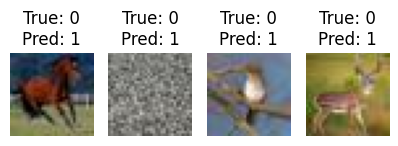

In [45]:
predicted_labels, true_labels = accuracy(test_loader, trained_model, device, threshold=0.6)

In [46]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# Accuracy: measures the proportion of correctly predicted instances out of the total instances.
accuracy = accuracy_score(true_labels, predicted_labels)

# Precision: measures the proportion of positive identifications that were actually correct.
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Recall: measures the proportion of actual positives that were correctly identified.
recall = recall_score(true_labels, predicted_labels, average='weighted')

# F1 score: harmonic mean of precision and recall. It balances the two metrics.
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Accuracy: 93.82%
Precision: 93.82%
Recall: 93.82%
F1 Score: 93.82%


A table used to evaluate the performance of a classification model.

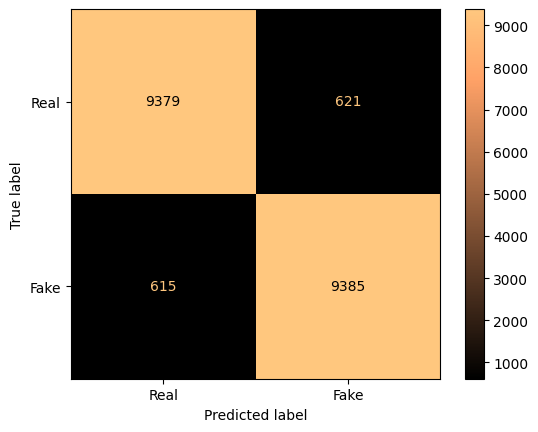

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Real", "Fake"])
disp.plot(cmap='copper')
plt.show()